# PyMX Septiembre 2023

## Usando Servicios Administrados de AI de AWS con Python y Boto3

![PyMX](images/pymx.png)

## Repository

### <https://gitlab.com/soldavid/pymx20230912>

![Presentation Link QR Code](images/qr.gif)

## David Sol

![David Sol](images/davidsol.jpg)

Born and living in México. Married with two children and one wonderful grandchild.

SRE @ Wizeline. AWS Community Builder.

Twitter: [@soldavidcloud](https://twitter.com/soldavidcloud)

Linkedin: <https://www.linkedin.com/in/soldavidcloud/>

- Favorite Book: **The Hitchhiker's Guide To the Galaxy (Douglas Adams)**
- Favorite Comic: **Planetary (Ellis/Cassaday)**
- Favorite Movie: **Flash Gordon (Mike Hodges 1980)**

![Favorites](images/favorites.jpeg)

## Machine Learning Services in the Cloud

![AWS ML Stack](images/aws-ai-ml-stack.jpg)


In [1]:
from pprint import pprint

from PIL import Image, ImageDraw, ImageFont

import boto3

## BOTO3

Boto3 es la libreria de acceso al API de AWS para Python (SDK).

Primero creamos una **sesión** (la cual no se "abre" hasta que la utilizamos). Necesitamos autenticarnos a AWS *(¡La seguridad primero!)*.

En mi caso voy a utilizar [un perfil ya definido en mi computadora](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html).

En el perfil se define que la región de AWS por omisión, que en este caso es us-west-2 (Oregon).

## Advertencia: NUNCA debes almacenar credenciales en un repositorio. No debes guardar el Notebook con credenciales.

In [2]:
aws_session = boto3.Session(
    profile_name="pymx"
)

In [3]:
pprint(aws_session.client("sts").get_caller_identity())

print(f"Región: {aws_session.region_name}")

{'Account': '424881583571',
 'Arn': 'arn:aws:iam::424881583571:user/pymx-ia',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '404',
                                      'content-type': 'text/xml',
                                      'date': 'Tue, 12 Sep 2023 20:27:57 GMT',
                                      'x-amzn-requestid': 'f60a129e-abce-43c7-9585-548baa8f2e21'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'f60a129e-abce-43c7-9585-548baa8f2e21',
                      'RetryAttempts': 0},
 'UserId': 'AIDAWF3HKOXJRCAUFO2S6'}
Región: us-west-2


## Rekognition

![Rekognition](images/rekognition.png)

Empezamos con el servicio de Vision, Rekognition. 

El procedimeinto con todos los servicios de AWS es primero crear un cliente de Boto3.


In [4]:
rekognition_client = aws_session.client('rekognition')


Elegimos la imagen a utilizar.

[*De la película Unfinished Business (2015)*](https://www.imdb.com/title/tt2358925/)

In [5]:
image_name = "images/sample.jpg"

Leemos la imagen.


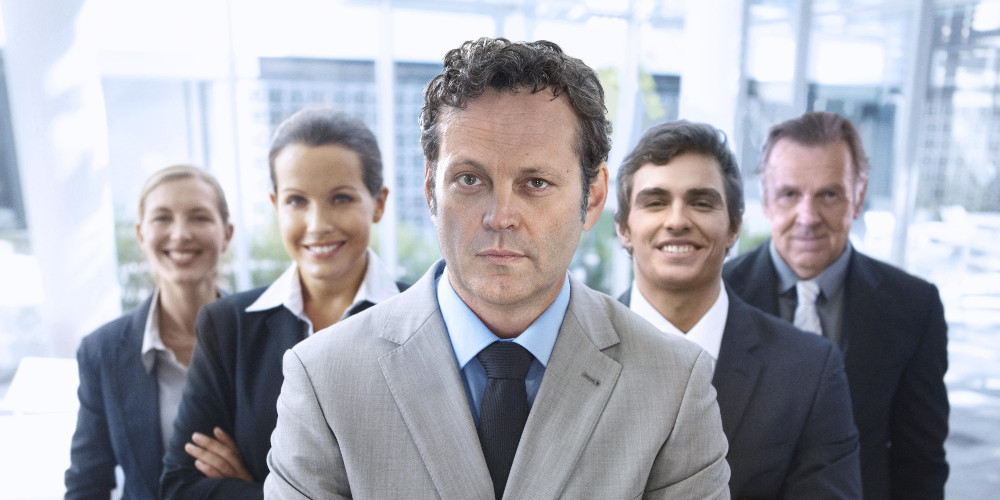

In [6]:
image_display = Image.open(image_name)
display(image_display)

Regoknition nos deja hacer muchas cosas, en este ejemplo vamos a identificar objetos en la imagen *(tagging)*.

Leemos la imagen como bytes y la enviamos a AWS para su analisis.

In [7]:
with open(image_name, 'rb') as image:
    response = rekognition_client.detect_labels(Image={'Bytes': image.read()})


La respuesta es un dicionario de Python.


In [8]:
pprint(response, depth=2)


{'LabelModelVersion': '3.0',
 'Labels': [{...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...},
            {...}],
 'ResponseMetadata': {'HTTPHeaders': {...},
                      'HTTPStatusCode': 200,
                      'RequestId': '48dda384-7e73-444a-bbe3-d847b52b9ed8',
                      'RetryAttempts': 0}}


In [9]:
pprint(response["Labels"][0:4], depth=2)


[{'Aliases': [...],
  'Categories': [...],
  'Confidence': 99.69816589355469,
  'Instances': [],
  'Name': 'Clothing',
  'Parents': []},
 {'Aliases': [],
  'Categories': [...],
  'Confidence': 99.69816589355469,
  'Instances': [],
  'Name': 'Formal Wear',
  'Parents': []},
 {'Aliases': [],
  'Categories': [...],
  'Confidence': 99.69816589355469,
  'Instances': [...],
  'Name': 'Suit',
  'Parents': [...]},
 {'Aliases': [],
  'Categories': [...],
  'Confidence': 99.53116607666016,
  'Instances': [...],
  'Name': 'Adult',
  'Parents': [...]}]


In [10]:
pprint(response["Labels"][2])

{'Aliases': [],
 'Categories': [{'Name': 'Apparel and Accessories'}],
 'Confidence': 99.69816589355469,
 'Instances': [{'BoundingBox': {'Height': 0.5283104181289673,
                                'Left': 0.7211247086524963,
                                'Top': 0.47134798765182495,
                                'Width': 0.2301754206418991},
                'Confidence': 99.69816589355469},
               {'BoundingBox': {'Height': 0.44372430443763733,
                                'Left': 0.6183088421821594,
                                'Top': 0.5550687313079834,
                                'Width': 0.24705761671066284},
                'Confidence': 99.56611633300781},
               {'BoundingBox': {'Height': 0.4831416606903076,
                                'Left': 0.2604919970035553,
                                'Top': 0.5167237520217896,
                                'Width': 0.47340258955955505},
                'Confidence': 99.28345489501953},
             

Separemos solo los labels en donde hay objetos detectados (los demás son categorias).

In [11]:
objetos_detectados = []

for label in response["Labels"]:
    if len(label["Instances"]) >= 1:
        print(label["Name"])
        objetos_detectados.append(label)

print(f"Total de tipo de objetos = {len(objetos_detectados)}")

Suit
Adult
Male
Man
Person
Female
Woman
Tie
Total de tipo de objetos = 8


Ahora empieza la diversión...


In [12]:
# Preparamos el canvas y el tipo de letra
font = ImageFont.truetype("Sudo-Bold.ttf", size=20)
draw = ImageDraw.Draw(image_display)
w, h = image_display.size


In [13]:
# Obtenemos la information de un tipo de objetos
nombre = objetos_detectados[0]["Name"]
print(f"Tipo de Objeto: {nombre}")
instancia = objetos_detectados[0]["Instances"][0]
print("Instancia: ")
pprint(instancia)
bbox = instancia["BoundingBox"]

# Transforma las coordenadas de porcentuales a absolutas
x0 = int(bbox["Left"] * w)
y0 = int(bbox["Top"] * h)
x1 = x0 + int(bbox["Width"] * w)
y1 = y0 + int(bbox["Height"] * h)
print("Coordenadas:", x0, y0, x1, y1)


Tipo de Objeto: Suit
Instancia: 
{'BoundingBox': {'Height': 0.5283104181289673,
                 'Left': 0.7211247086524963,
                 'Top': 0.47134798765182495,
                 'Width': 0.2301754206418991},
 'Confidence': 99.69816589355469}
Coordenadas: 721 235 951 499


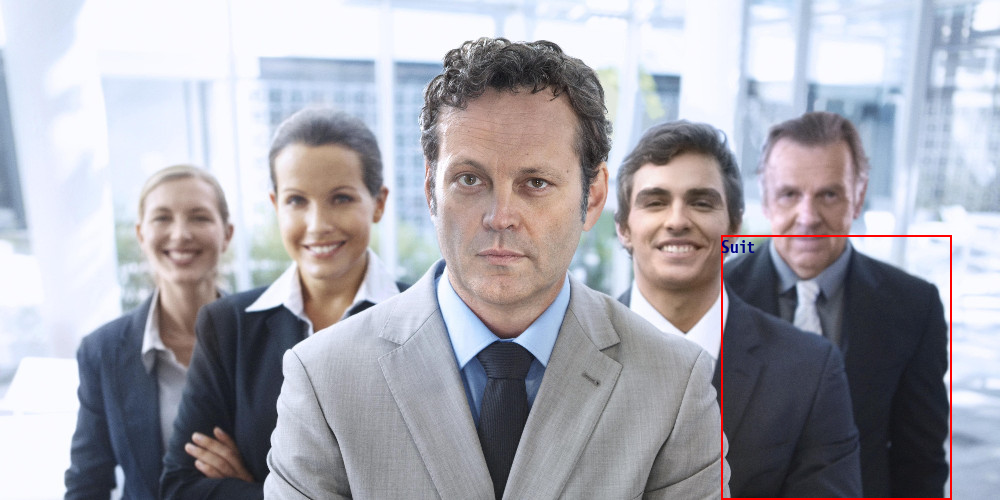

In [14]:
# Dibujamos un rectángulo y el nombre sobre el canvas
draw.rectangle(
    (x0, y0, x1, y1),
    outline=(255, 0, 0),
    width=2
)
draw.text(
    (x0, y0),
    nombre,
    font=font,
    fill=(0, 0, 128)
)
display(image_display)


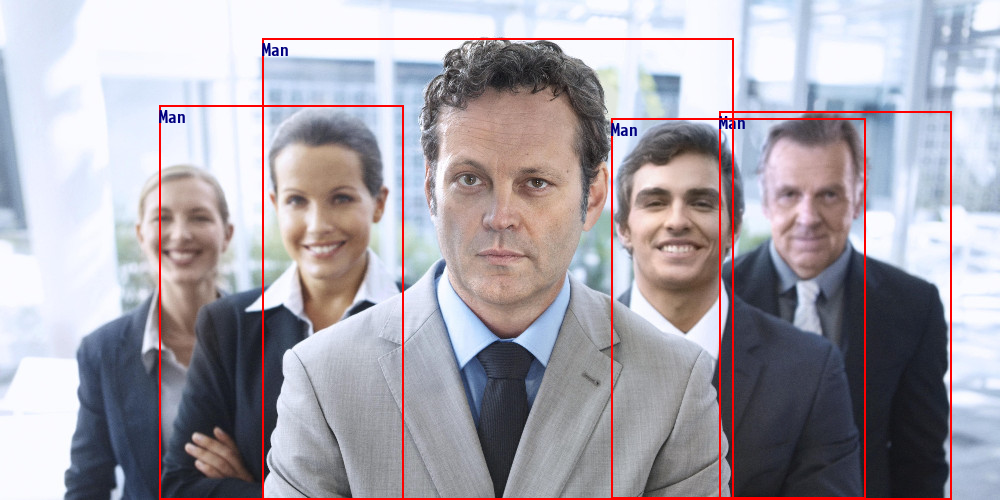

In [15]:
# Ahora hagamoslo para todas las instancias de un tipo de objeto
# Podemos variar el índice para ver diferentes tipos de objeto
indice = 3
image_display = Image.open(image_name)
draw = ImageDraw.Draw(image_display)
tipo_objeto = objetos_detectados[indice]
nombre = tipo_objeto["Name"]
for instancia in tipo_objeto["Instances"]:
    bbox = instancia["BoundingBox"]
    x0 = int(bbox["Left"] * w)
    y0 = int(bbox["Top"] * h)
    x1 = x0 + int(bbox["Width"] * w)
    y1 = y0 + int(bbox["Height"] * h)
    draw.rectangle((x0, y0, x1, y1), outline=(255, 0, 0), width=2)
    draw.text((x0, y0), nombre, font=font, fill=(0, 0, 128))

display(image_display)


## Polly

We can also synthesize audio.

![AWS Polly](images/polly.jpg)


In [16]:
from botocore.exceptions import BotoCoreError, ClientError
from contextlib import closing
import os
import sys
import subprocess
from tempfile import gettempdir

polly = aws_session.client("polly")

try:
    # Solicitamos la síntesis de audio
    response = polly.synthesize_speech(
        Text="Aprendizaje Automatizado e Inteligencia Artificial tienen un desarrollo acelerado últimamente.",
        OutputFormat="mp3",
        VoiceId="Mia",
        Engine="neural",
    )
    # Tambien podemos probar con Lupe o Lucia
    # Todos los lenguajes y voces están documentados en https://docs.aws.amazon.com/polly/latest/dg/voicelist.html
except (BotoCoreError, ClientError) as error:
    # El servicio respondió un error
    print(error)


In [17]:
# Salvamos el stream de audio de la respuesta a un archivo.
output = ""
if "AudioStream" in response:
    with closing(response["AudioStream"]) as stream:
        output = os.path.join(gettempdir(), "narracion.mp3")
        try:
            with open(output, "wb") as file:
                file.write(stream.read())
        except IOError as error:
            print(error)
            sys.exit(-1)
else:
    print("Could not stream audio")

# Reproducimos el audio
if sys.platform == "win32":
    # The following works on Windows
    os.startfile(output)
else:
    opener = "open" if sys.platform == "darwin" else "xdg-open"
    subprocess.call([opener, output])
print (output)


/var/folders/97/gsdyvg5s4cx9h0_p_g19rqqc0000gn/T/narracion.mp3


## Transcribe

Y podemos hacer lo contrario, transcribir audio a texto.

Nuestro archivo de ejemplo está en (https://david21-publica.s3.us-west-2.amazonaws.com/ejemplo.mp3).
![Transcribe Logo](images/transcribe.jpg)


In [18]:
import time

transcribe_client = aws_session.client('transcribe')

transcription_job_name="pymx-00-debe-ser-un-valor-unico-cada-vez"
transcript_uri = ""

transcribe_client.start_transcription_job(
    TranscriptionJobName=transcription_job_name,
    Media={"MediaFileUri": "s3://david21-publica/ejemplo.mp3"},
    MediaFormat="mp3",
    LanguageCode="es-ES"
)

# Es un proceso asíncrono, y hay que esperar a que termine
max_tries = 60
while max_tries > 0:
    max_tries -= 1
    job = transcribe_client.get_transcription_job(TranscriptionJobName=transcription_job_name)
    job_status = job["TranscriptionJob"]["TranscriptionJobStatus"]
    if job_status in ["COMPLETED", "FAILED"]:
        print(f"El estado de la transcripción es: {job_status}.")
        if job_status == "COMPLETED":
            transcript_uri = job["TranscriptionJob"]["Transcript"]["TranscriptFileUri"]
            print(
                f"Download the transcript from\n"
                f"\t{transcript_uri}."
            )
        break
    else:
        print(f"Seguimos esperando. El estado actual es {job_status}.")
    time.sleep(10)


Seguimos esperando. El estado actual es IN_PROGRESS.
Seguimos esperando. El estado actual es IN_PROGRESS.
Seguimos esperando. El estado actual es IN_PROGRESS.
El estado de la transcripción es: COMPLETED.
Download the transcript from
	https://s3.us-west-2.amazonaws.com/aws-transcribe-us-west-2-prod/424881583571/pymx-00-debe-ser-un-valor-unico-cada-vez/0be8acac-c5c5-41ec-915f-6b496323acef/asrOutput.json?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEDQaCXVzLXdlc3QtMiJGMEQCIDAJVXuyBCsmdQb%2Bom09y2xti2Jyv0ybyk8B%2FVeKGJZZAiBuqyLbkTW%2F%2BhQVuMoNVX6Iy1MxL8FxDrAmpsrTs5lHeiqyBQgcEAQaDDA4MDI0ODMyMjIwNiIMocLMcfQb1%2BYkGWYjKo8F2rT2nHFicjnsjhjTYBcy68vzhA5udLJ%2FbonKwAHRVL96riyA%2FWPHI5Y%2FBlNde3Im6mUTbxl2z0HmIPDQQAVaqBAecj9hwmF43R8mOne1hKu%2FlhvrgVs6MU3kH538c5cTDnSeo9ITR%2FOSLttcBjN0HiQRxmITuUP%2BxGaf6OmbW7z7CVkEGFhL1159UUIvECgLXiwvcfS2310FQVUZ9m1alFQAJzvgiteg74kVZspspGDJqU90DSRVsCCajxSEC7nUTojC86zn1gOIH7wBXKEEzlVZDmpSdscPD5CyuNREskHtv0w8tDtqnb5lqGXBUnEyW2kLWHBOpPxmX%2BXFsDhFGnYvlBqpeeIuTJDYaf9iLaAptXhLcW

In [19]:
import requests

response = requests.get(transcript_uri)

pprint(response.json(), depth=2)


{'accountId': '424881583571',
 'jobName': 'pymx-00-debe-ser-un-valor-unico-cada-vez',
 'results': {'items': [...], 'transcripts': [...]},
 'status': 'COMPLETED'}


In [20]:
print(response.json()["results"]["transcripts"][0]["transcript"])


la inteligencia artificial y el aprendizaje automatizado. Es un tópico muy interesante.


In [21]:
pprint(response.json()["results"]["items"])


[{'alternatives': [{'confidence': '0.999', 'content': 'la'}],
  'end_time': '0.239',
  'start_time': '0.1',
  'type': 'pronunciation'},
 {'alternatives': [{'confidence': '0.997', 'content': 'inteligencia'}],
  'end_time': '0.98',
  'start_time': '0.25',
  'type': 'pronunciation'},
 {'alternatives': [{'confidence': '0.995', 'content': 'artificial'}],
  'end_time': '1.58',
  'start_time': '0.99',
  'type': 'pronunciation'},
 {'alternatives': [{'confidence': '0.999', 'content': 'y'}],
  'end_time': '1.7',
  'start_time': '1.59',
  'type': 'pronunciation'},
 {'alternatives': [{'confidence': '0.997', 'content': 'el'}],
  'end_time': '1.799',
  'start_time': '1.71',
  'type': 'pronunciation'},
 {'alternatives': [{'confidence': '0.996', 'content': 'aprendizaje'}],
  'end_time': '2.5',
  'start_time': '1.809',
  'type': 'pronunciation'},
 {'alternatives': [{'confidence': '0.982', 'content': 'automatizado'}],
  'end_time': '3.359',
  'start_time': '2.509',
  'type': 'pronunciation'},
 {'alterna

## Translate

También podemos traducir entre lenguajes.

![Translate Logo](images/translate.png)


In [22]:
translate = aws_session.client(service_name="translate")

# Los lenguajes disponibles están documentados en https://docs.aws.amazon.com/translate/latest/dg/what-is-languages.html.

result = translate.translate_text(
    Text="Machine Learning is a very interesting subject",
    SourceLanguageCode="en",
    TargetLanguageCode="zh"
)

print('Traducción: ' + result.get('TranslatedText'))


Traducción: 机器学习是一个非常有趣的话题


## Comprehend

Mas interesante, analizar el texto para encontrar su significado.

![Comprehend](images/comprehend.png)


In [23]:
class ComprehendDetect:
    """Encapsulates Comprehend detection functions."""
    def __init__(self, comprehend_client):
        """
        :param comprehend_client: A Boto3 Comprehend client.
        """
        self.comprehend_client = comprehend_client


    def detect_languages(self, text):
        """
        Detects languages used in a document.

        :param text: The document to inspect.
        :return: The list of languages along with their confidence scores.
        """
        try:
            response = self.comprehend_client.detect_dominant_language(Text=text)
            languages = response['Languages']
        except ClientError:
            print("Couldn't detect languages.")
            raise
        else:
            return languages

    def detect_entities(self, text, language_code):
        """
        Detects entities in a document. Entities can be things like people and places
        or other common terms.

        :param text: The document to inspect.
        :param language_code: The language of the document.
        :return: The list of entities along with their confidence scores.
        """
        try:
            response = self.comprehend_client.detect_entities(
                Text=text, LanguageCode=language_code)
            entities = response['Entities']
        except ClientError:
            print("Couldn't detect entities.")
            raise
        else:
            return entities

    def detect_key_phrases(self, text, language_code):
        """
        Detects key phrases in a document. A key phrase is typically a noun and its
        modifiers.

        :param text: The document to inspect.
        :param language_code: The language of the document.
        :return: The list of key phrases along with their confidence scores.
        """
        try:
            response = self.comprehend_client.detect_key_phrases(
                Text=text, LanguageCode=language_code)
            phrases = response['KeyPhrases']
        except ClientError:
            print("Couldn't detect phrases.")
            raise
        else:
            return phrases

    def detect_pii(self, text, language_code):
        """
        Detects personally identifiable information (PII) in a document. PII can be
        things like names, account numbers, or addresses.

        :param text: The document to inspect.
        :param language_code: The language of the document.
        :return: The list of PII entities along with their confidence scores.
        """
        try:
            response = self.comprehend_client.detect_pii_entities(
                Text=text, LanguageCode=language_code)
            entities = response['Entities']
        except ClientError:
            print("Couldn't detect PII entities.")
            raise
        else:
            return entities

    def detect_sentiment(self, text, language_code):
        """
        Detects the overall sentiment expressed in a document. Sentiment can
        be positive, negative, neutral, or a mixture.

        :param text: The document to inspect.
        :param language_code: The language of the document.
        :return: The sentiments along with their confidence scores.
        """
        try:
            response = self.comprehend_client.detect_sentiment(
                Text=text, LanguageCode=language_code)
        except ClientError:
            print("Couldn't detect sentiment.")
            raise
        else:
            return response

    def detect_syntax(self, text, language_code):
        """
        Detects syntactical elements of a document. Syntax tokens are portions of
        text along with their use as parts of speech, such as nouns, verbs, and
        interjections.

        :param text: The document to inspect.
        :param language_code: The language of the document.
        :return: The list of syntax tokens along with their confidence scores.
        """
        try:
            response = self.comprehend_client.detect_syntax(
                Text=text, LanguageCode=language_code)
            tokens = response['SyntaxTokens']
        except ClientError:
            print("Couldn't detect syntax.")
            raise
        else:
            return tokens


In [24]:
comprehend = ComprehendDetect(aws_session.client('comprehend'))

sample_text = """
No amo mi patria.
Su fulgor abstracto
      es inasible.
Pero (aunque suene mal)
      daría la vida
por diez lugares suyos,
      cierta gente,
puertos, bosques de pinos,
      fortalezas,
una ciudad deshecha,
     gris, monstruosa,
varias figuras de su historia,
      montañas
y tres o cuatro ríos
"""

demo_size = 5

print("Detectando Lenguaje.")
languages = comprehend.detect_languages(sample_text)
pprint(languages)
lang_code = languages[0]['LanguageCode']

print("Detectando Entidades.")
entities = comprehend.detect_entities(sample_text, lang_code)
print(f"Las primeras {demo_size} entidades son:")
pprint(entities[:demo_size])

print("Detectando Frases Importantes.")
phrases = comprehend.detect_key_phrases(sample_text, lang_code)
print(f"Las primeras {demo_size} frases importantes son:")
pprint(phrases[:demo_size])

print("Detectando Sentimiento.")
sentiment = comprehend.detect_sentiment(sample_text, lang_code)
print(f"Sentimiento: {sentiment['Sentiment']}")
print("Calificación:")
pprint(sentiment['SentimentScore'])

print("Analizando Sintaxis.")
syntax_tokens = comprehend.detect_syntax(sample_text, lang_code)
print(f"Los primeros {demo_size} elementos son:")
pprint(syntax_tokens[:demo_size])


Detectando Lenguaje.
[{'LanguageCode': 'es', 'Score': 0.9879986643791199}]
Detectando Entidades.
Las primeras 5 entidades son:
[{'BeginOffset': 106,
  'EndOffset': 118,
  'Score': 0.9967193603515625,
  'Text': 'diez lugares',
  'Type': 'QUANTITY'},
 {'BeginOffset': 235,
  'EndOffset': 249,
  'Score': 0.7145171165466309,
  'Text': 'varias figuras',
  'Type': 'QUANTITY'},
 {'BeginOffset': 283,
  'EndOffset': 287,
  'Score': 0.9685515761375427,
  'Text': 'tres',
  'Type': 'QUANTITY'},
 {'BeginOffset': 290,
  'EndOffset': 301,
  'Score': 0.6481868028640747,
  'Text': 'cuatro ríos',
  'Type': 'QUANTITY'}]
Detectando Frases Importantes.
Las primeras 5 frases importantes son:
[{'BeginOffset': 8,
  'EndOffset': 17,
  'Score': 0.9999383687973022,
  'Text': 'mi patria'},
 {'BeginOffset': 19,
  'EndOffset': 38,
  'Score': 0.9998927712440491,
  'Text': 'Su fulgor abstracto'}]
Detectando Sentimiento.
Sentimiento: NEGATIVE
Calificación:
{'Mixed': 0.48861902952194214,
 'Negative': 0.4909053444862366,

## Sagemaker

![Sagemaker Logo](images/sagemaker.jpg)

También hay servicios que te dan acceso a un ambiente de trabajo de Machine Learning completo, incluyendo almacenamiento de datos, securidad, flujos de trabajo automatizados, recursos de cómputo bajo demanda y despliegue de modelos.

![MLOps Platform](images/MLOps%20Platform.jpeg)

En particular hay un servicio gratuito para Aprendizaje Automatizado y realización de experimientos simples.

[Amazon Sagemaker Studio Lab](https://studiolab.sagemaker.aws)

## Hugging Face

Les recomiendo revisar este recurso: [Hugging Face](https://huggingface.co). Es una colección de algoritmos, modelos y herramientas de código abierto para Machine Learning e Inteligencia Artificial.

![Hugging Face Logo](images/huggingface-logo.png)

## Otros proveedores de nube.

Claro, AWS no es el único proveedor de nube. También hay ofertas muy completas de **Google Cloud Platform** and **Microsoft Azure**.

También hay proveedores *pequeños* que podemos utilizar, y casi todos con un ambiente gratuito. Algunos de ellos son:

- [Dataiku](https://www.dataiku.com/product/)
- [Google Colab](https://colab.research.google.com)
- [JetBrains Datalore](https://datalore.jetbrains.com)
- [Kaggle](https://www.kaggle.com)
- [Paperspace](https://www.paperspace.com)

Y, por supuesto, [Binder](https://mybinder.org), si lo quieren poder ver y ejecutar Jupyter Notebooks.

## Gracias

## Repositorio

### <https://gitlab.com/soldavid/pymx20230912>

![Presentation Link QR Code](images/qr.gif)